In [1]:
# ===== SETUP & DATA LOADING =====
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata

print("📥 Loading data from NYC Open Data API...")
client = Socrata("data.cityofnewyork.us", None)

# Load data from July 2024 onwards (to cover all events)
print("   Loading data from July 2024...")
results = client.get("8h9b-rp9u", 
                     where="arrest_date >= '2024-07-01T00:00:00'",
                     limit=150000)
df = pd.DataFrame.from_records(results)
print(f"   {len(df):,} raw arrests loaded")

📥 Loading data from NYC Open Data API...
   Loading data from July 2024...
   131,710 raw arrests loaded


In [2]:


# Crime filter
relevant_crimes = ['ROBBERY', 'ASSAULT 3 & RELATED OFFENSES', 
                   'DANGEROUS DRUGS', 'PETIT LARCENY', 'CRIMINAL TRESPASS']

# Preprocessing pipeline
df_spatial = (df[df['ofns_desc'].isin(relevant_crimes)]
              .dropna(subset=['latitude', 'longitude'])
              .assign(latitude=lambda x: pd.to_numeric(x['latitude'], errors='coerce'),
                     longitude=lambda x: pd.to_numeric(x['longitude'], errors='coerce'),
                     arrest_date=lambda x: pd.to_datetime(x['arrest_date']))
              .query('40.0 < latitude < 41.0 and -75.0 < longitude < -73.0')
              [['arrest_key', 'arrest_date', 'ofns_desc', 'arrest_boro', 'latitude', 'longitude']]
              .dropna())

print(f"✅ Loaded: {len(df_spatial):,} arrests | Range: {df_spatial['arrest_date'].min()} to {df_spatial['arrest_date'].max()}")

✅ Loaded: 50,077 arrests | Range: 2024-07-01 00:00:00 to 2024-12-31 00:00:00


In [3]:
# ========================================
# MULTI-EVENT ANALYSIS: 5 HOLIDAYS/EVENTS
# ========================================

events_2024 = {
    'Halloween': {
        'date': '2024-10-31',
        'day': 'Thursday',
        'baseline': ['2024-10-03', '2024-10-10', '2024-10-17', '2024-10-24']
    },
    
    'Thanksgiving': {
        'date': '2024-11-28',
        'day': 'Thursday',
        'baseline': ['2024-11-07', '2024-11-14', '2024-11-21']
    },
    
    'Independence Day': {
        'date': '2024-07-04',
        'day': 'Thursday',
        'baseline': ['2024-07-11', '2024-07-18', '2024-07-25']
    },
    
    'New Year Eve': {
        'date': '2024-12-31',
        'day': 'Tuesday',
        'baseline': ['2024-12-03', '2024-12-10', '2024-12-17', '2024-12-24']
    },
    
    'NYC Marathon': {
        'date': '2024-11-03',
        'day': 'Sunday',
        'baseline': ['2024-11-10', '2024-11-17', '2024-11-24']
    }
}

print("🎉 MULTI-EVENT CRIME DISTRIBUTION ANALYSIS")
print("="*80)

# Function: Calculate crime distribution
def get_crime_distribution_multi(data, relevant_crimes):
    """Calculates crime distribution as percent and absolute counts"""
    crime_counts = {}
    total = len(data)
    for crime in relevant_crimes:
        count = len(data[data['ofns_desc'] == crime])
        crime_counts[crime] = {
            'count': count, 
            'percent': (count/total*100) if total > 0 else 0
        }
    return crime_counts, total

# Storage for all results
all_results = {}

# Analyze each event
for event_name, event_info in events_2024.items():
    print(f"\n{'='*80}")
    print(f"🎯 {event_name} ({event_info['date']} - {event_info['day']})")
    print(f"{'='*80}")
    
    # Load event day
    event_date = pd.to_datetime(event_info['date'])
    event_data = df_spatial[df_spatial['arrest_date'].dt.date == event_date.date()].copy()
    
    # Load baseline days
    baseline_dates = [pd.to_datetime(d) for d in event_info['baseline']]
    baseline_data = pd.concat([
        df_spatial[df_spatial['arrest_date'].dt.date == d.date()] 
        for d in baseline_dates
    ])
    
    # Calculate crime distributions
    event_dist, event_total = get_crime_distribution_multi(event_data, relevant_crimes)
    baseline_dist, baseline_total = get_crime_distribution_multi(baseline_data, relevant_crimes)
    
    # Calculate changes
    changes = {}
    for crime in relevant_crimes:
        baseline_pct = baseline_dist[crime]['percent']
        event_pct = event_dist[crime]['percent']
        changes[crime] = event_pct - baseline_pct
    
    # Save results
    baseline_avg = baseline_total / len(baseline_dates) if len(baseline_dates) > 0 else 0
    all_results[event_name] = {
        'event_dist': event_dist,
        'baseline_dist': baseline_dist,
        'changes': changes,
        'event_total': event_total,
        'baseline_total': baseline_total,
        'baseline_avg': baseline_avg
    }
    
    # Output with null-check
    print(f"  Event: {event_total:,} Arrests")
    if baseline_avg > 0:
        print(f"  Baseline: {baseline_total:,} Arrests (Ø {baseline_avg:.0f} per day)")
        diff_pct = ((event_total/baseline_avg - 1) * 100) if baseline_avg > 0 else 0
        print(f"  Difference: {event_total - baseline_avg:.0f} Arrests ({diff_pct:+.1f}%)")
    else:
        print(f"  ⚠️  No baseline data available!")

print(f"\n{'='*80}")
print("✅ All events analyzed!")
print(f"{'='*80}")

🎉 MULTI-EVENT CRIME DISTRIBUTION ANALYSIS

🎯 Halloween (2024-10-31 - Thursday)
  Event: 215 Arrests
  Baseline: 1,240 Arrests (Ø 310 per day)
  Difference: -95 Arrests (-30.6%)

🎯 Thanksgiving (2024-11-28 - Thursday)
  Event: 127 Arrests
  Baseline: 991 Arrests (Ø 330 per day)
  Difference: -203 Arrests (-61.6%)

🎯 Independence Day (2024-07-04 - Thursday)
  Event: 211 Arrests
  Baseline: 862 Arrests (Ø 287 per day)
  Difference: -76 Arrests (-26.6%)

🎯 New Year Eve (2024-12-31 - Tuesday)
  Event: 159 Arrests
  Baseline: 1,116 Arrests (Ø 279 per day)
  Difference: -120 Arrests (-43.0%)

🎯 NYC Marathon (2024-11-03 - Sunday)
  Event: 196 Arrests
  Baseline: 685 Arrests (Ø 228 per day)
  Difference: -32 Arrests (-14.2%)

✅ All events analyzed!


C:\Users\Janti\AppData\Local\Temp\ipykernel_1408\2854087489.py:99: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Janti\AppData\Local\Temp\ipykernel_1408\2854087489.py:100: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  plt.savefig('multi_event_crime_distribution.png', dpi=300, bbox_inches='tight')


✅ Saved: multi_event_crime_distribution.png


c:\Users\Janti\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


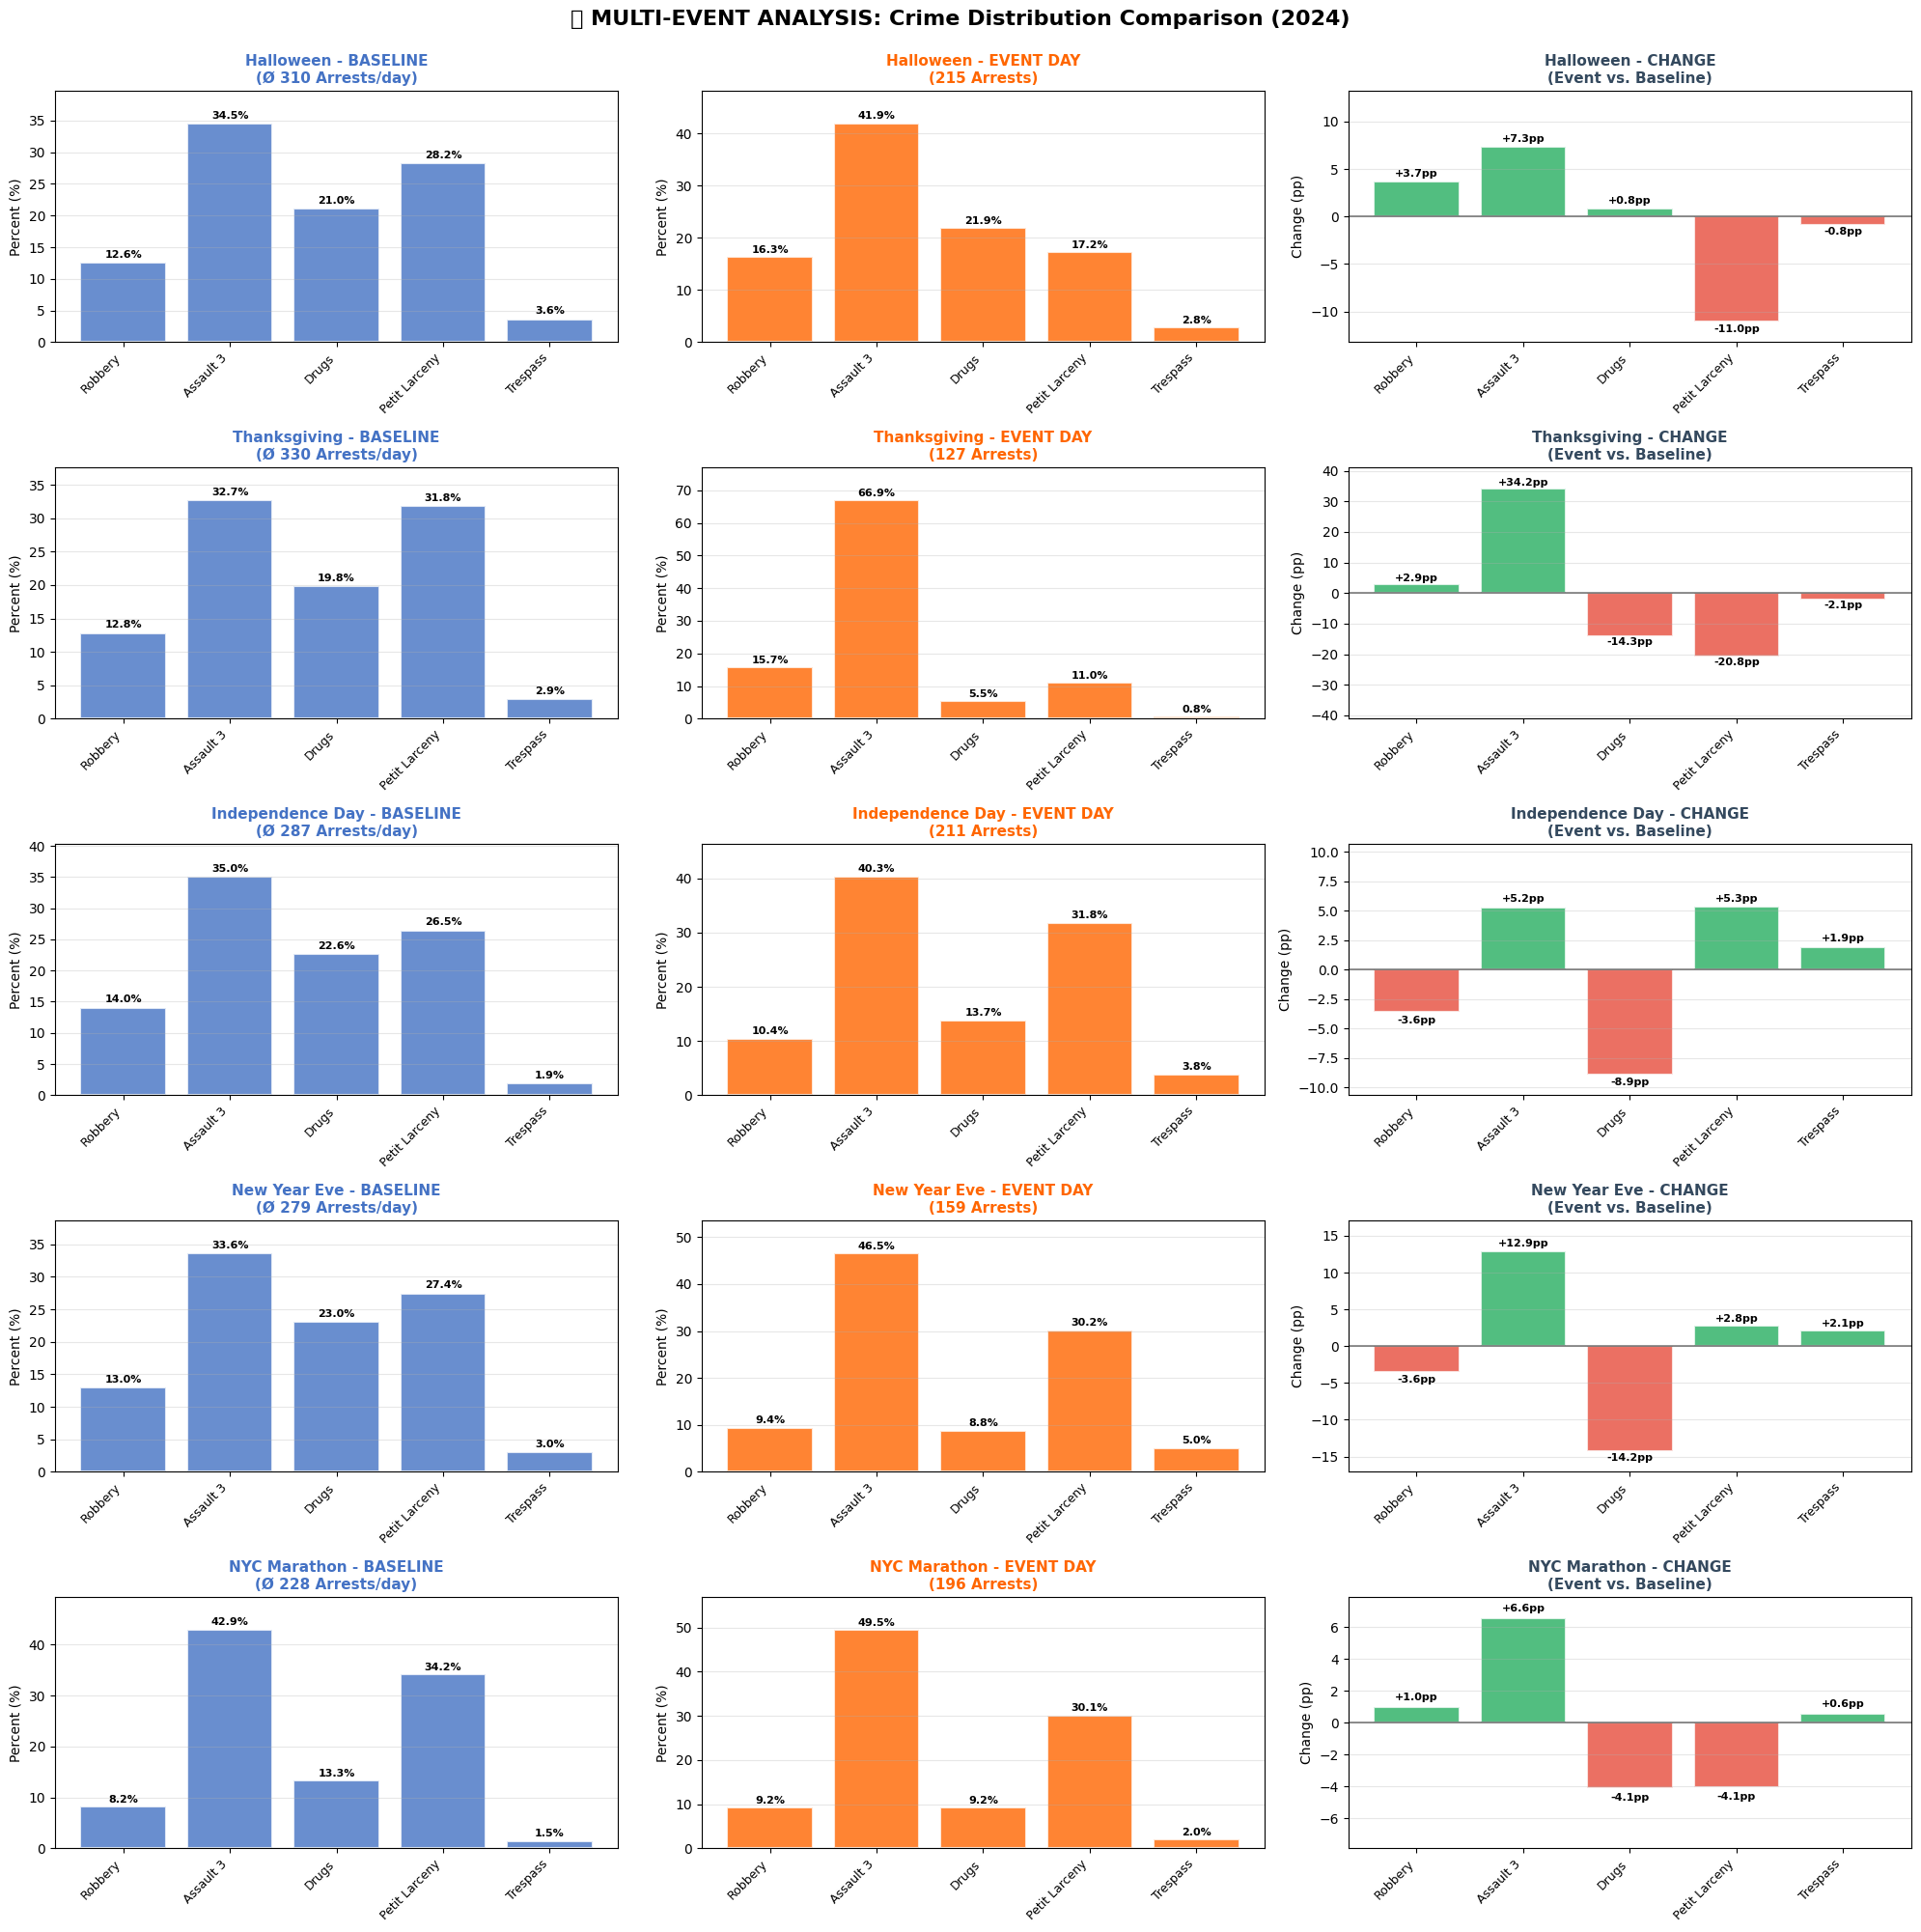

In [4]:
# ========================================
# VISUALIZATION: ALL EVENTS
# ========================================

# Short crime names
crime_labels = {
    'ROBBERY': 'Robbery',
    'ASSAULT 3 & RELATED OFFENSES': 'Assault 3',
    'FELONY ASSAULT': 'Felony Assault',
    'DANGEROUS DRUGS': 'Drugs',
    'PETIT LARCENY': 'Petit Larceny',
    'CRIMINAL TRESPASS': 'Trespass'
}

n_events = len(events_2024)
n_crimes = len(relevant_crimes)

# ===== LAYOUT: 5 Events x 3 Plots (Baseline, Event, Change) =====
fig, axes = plt.subplots(n_events, 3, figsize=(20, 4*n_events))

event_names = list(events_2024.keys())
x_pos = np.arange(n_crimes)
short_labels = [crime_labels.get(c, c) for c in relevant_crimes]

for idx, event_name in enumerate(event_names):
    result = all_results[event_name]
    baseline_dist = result['baseline_dist']
    event_dist = result['event_dist']
    changes = result['changes']
    
    # Row for this event
    ax_baseline = axes[idx, 0]
    ax_event = axes[idx, 1]
    ax_change = axes[idx, 2]
    
    # ===== PLOT 1: BASELINE =====
    baseline_percents = [baseline_dist[c]['percent'] for c in relevant_crimes]
    bars = ax_baseline.bar(x_pos, baseline_percents, color='#4472C4', alpha=0.8, edgecolor='white', linewidth=1.5)
    
    # Labels
    for bar, pct in zip(bars, baseline_percents):
        height = bar.get_height()
        ax_baseline.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                        f'{pct:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax_baseline.set_title(f'{event_name} - BASELINE\n(Ø {result["baseline_avg"]:.0f} Arrests/day)',
                         fontsize=11, fontweight='bold', color='#4472C4')
    ax_baseline.set_ylabel('Percent (%)', fontsize=10)
    ax_baseline.set_xticks(x_pos)
    ax_baseline.set_xticklabels(short_labels, rotation=45, ha='right', fontsize=9)
    ax_baseline.set_ylim(0, max(baseline_percents) * 1.15)
    ax_baseline.grid(axis='y', alpha=0.3)
    
    # ===== PLOT 2: EVENT =====
    event_percents = [event_dist[c]['percent'] for c in relevant_crimes]
    bars = ax_event.bar(x_pos, event_percents, color='#FF6600', alpha=0.8, edgecolor='white', linewidth=1.5)
    
    # Labels
    for bar, pct in zip(bars, event_percents):
        height = bar.get_height()
        ax_event.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                     f'{pct:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax_event.set_title(f'{event_name} - EVENT DAY\n({result["event_total"]:,} Arrests)',
                      fontsize=11, fontweight='bold', color='#FF6600')
    ax_event.set_ylabel('Percent (%)', fontsize=10)
    ax_event.set_xticks(x_pos)
    ax_event.set_xticklabels(short_labels, rotation=45, ha='right', fontsize=9)
    ax_event.set_ylim(0, max(event_percents) * 1.15)
    ax_event.grid(axis='y', alpha=0.3)
    
    # ===== PLOT 3: CHANGE =====
    change_values = [changes[c] for c in relevant_crimes]
    colors_change = ['#27AE60' if v > 0 else '#E74C3C' for v in change_values]
    bars = ax_change.bar(x_pos, change_values, color=colors_change, alpha=0.8, edgecolor='white', linewidth=1.5)
    
    # Labels
    for bar, val in zip(bars, change_values):
        height = bar.get_height()
        label_y = height + 0.3 if height > 0 else height - 0.3
        va = 'bottom' if height > 0 else 'top'
        ax_change.text(bar.get_x() + bar.get_width()/2, label_y,
                      f'{val:+.1f}pp', ha='center', va=va, fontsize=8, fontweight='bold')
    
    # Zero line
    ax_change.axhline(y=0, color='black', linewidth=1.2, linestyle='-', alpha=0.5)
    
    ax_change.set_title(f'{event_name} - CHANGE\n(Event vs. Baseline)',
                       fontsize=11, fontweight='bold', color='#34495E')
    ax_change.set_ylabel('Change (pp)', fontsize=10)
    ax_change.set_xticks(x_pos)
    ax_change.set_xticklabels(short_labels, rotation=45, ha='right', fontsize=9)
    y_max = max(abs(min(change_values)), abs(max(change_values)), 5) * 1.2
    ax_change.set_ylim(-y_max, y_max)
    ax_change.grid(axis='y', alpha=0.3)

plt.suptitle('🎉 MULTI-EVENT ANALYSIS: Crime Distribution Comparison (2024)', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.savefig('multi_event_crime_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Saved: multi_event_crime_distribution.png")
plt.show()

In [5]:
# ========================================
# FINAL SUMMARY TABLE
# ========================================

# Define crime labels (if not present)
crime_labels = {
    'ROBBERY': 'Robbery',
    'ASSAULT 3 & RELATED OFFENSES': 'Assault 3',
    'FELONY ASSAULT': 'Felony Assault',
    'DANGEROUS DRUGS': 'Drugs',
    'PETIT LARCENY': 'Petit Larceny',
    'CRIMINAL TRESPASS': 'Trespass'
}

print("\n" + "="*120)
print("📊 CRIME DISTRIBUTION: ALL EVENTS SUMMARY")
print("="*120)

# Create header
print(f"\n{'Crime Type':<20}", end="")
for event_name in event_names:
    print(f"│ {event_name:<15}", end="")
print(f"│ {'Ø CHANGE':<15}")

print(f"{'='*20}", end="")
for _ in event_names:
    print(f"┼{'='*16}", end="")
print(f"┼{'='*16}")

# Subheader: Baseline | Event | Δ for each event + average
print(f"{'(% of Arrests)':<20}", end="")
for event_name in event_names:
    print(f"│ {'Base|Evnt|Δ':<15}", end="")
print(f"│ {'across Events':<15}")

print(f"{'-'*20}", end="")
for _ in event_names:
    print(f"┼{'-'*16}", end="")
print(f"┼{'-'*16}")

# For each crime type
for crime in relevant_crimes:
    short_name = crime_labels.get(crime, crime)[:18]
    print(f"{short_name:<20}", end="")
    
    # Collect changes for average
    all_changes_for_crime = []
    
    for event_name in event_names:
        result = all_results[event_name]
        baseline_pct = result['baseline_dist'][crime]['percent']
        event_pct = result['event_dist'][crime]['percent']
        change = result['changes'][crime]
        all_changes_for_crime.append(change)
        
        # Format: Baseline | Event | Δ
        print(f"│ {baseline_pct:4.1f} {event_pct:4.1f} {change:+5.1f}", end="")
    
    # Average change across all events
    avg_change = np.mean(all_changes_for_crime)
    print(f"│ {avg_change:+7.2f}pp")

print(f"{'='*20}", end="")
for _ in event_names:
    print(f"┼{'='*16}", end="")
print(f"┼{'='*16}")

# ===== AVERAGE ARRESTS PER EVENT =====
print(f"\n{'TOTAL ARRESTS':<20}", end="")
for event_name in event_names:
    result = all_results[event_name]
    baseline_avg = result['baseline_avg']
    event_total = result['event_total']
    diff = event_total - baseline_avg
    diff_pct = (diff / baseline_avg) * 100 if baseline_avg > 0 else 0
    
    print(f"│ {baseline_avg:4.0f} {event_total:4.0f} {diff_pct:+5.1f}%", end="")

# Average across all events
avg_baseline = np.mean([r['baseline_avg'] for r in all_results.values()])
avg_event = np.mean([r['event_total'] for r in all_results.values()])
avg_diff_pct = ((avg_event - avg_baseline) / avg_baseline) * 100 if avg_baseline > 0 else 0
print(f"│ {avg_diff_pct:+7.2f}%")

print(f"{'='*20}", end="")
for _ in event_names:
    print(f"┼{'='*16}", end="")
print(f"┼{'='*16}")

# ===== INTERPRETATION =====
print("\n" + "="*120)
print("💡 INTERPRETATION: Average Changes Across All Events")
print("="*120)

# Calculate average change per crime type
avg_changes_per_crime = {}
for crime in relevant_crimes:
    changes_list = [all_results[e]['changes'][crime] for e in event_names]
    avg_changes_per_crime[crime] = np.mean(changes_list)

# Sort by magnitude of change
sorted_avg_changes = sorted(avg_changes_per_crime.items(), key=lambda x: x[1], reverse=True)

print("\n✅ More FREQUENT at Events (Top 3):")
for crime, avg_change in sorted_avg_changes[:3]:
    if avg_change > 0:
        short_name = crime_labels.get(crime, crime)
        print(f"   • {short_name}: +{avg_change:.2f} percentage points")
    else:
        break

print("\n❌ LESS FREQUENT at Events (Top 3):")
for crime, avg_change in sorted_avg_changes[-3:]:
    if avg_change < 0:
        short_name = crime_labels.get(crime, crime)
        print(f"   • {short_name}: {avg_change:.2f} percentage points")

print("\n📊 Event Effect on Total Count:")
if avg_diff_pct < -10:
    print(f"   ❌ Events have on average {abs(avg_diff_pct):.1f}% FEWER Arrests (Holiday Effect!)")
elif avg_diff_pct > 10:
    print(f"   ⚠️  Events have on average {avg_diff_pct:.1f}% MORE Arrests")
else:
    print(f"   ➡️  Events have similar arrest counts ({avg_diff_pct:+.1f}%)")

print("\n" + "="*120)


📊 CRIME DISTRIBUTION: ALL EVENTS SUMMARY

Crime Type          │ Halloween      │ Thanksgiving   │ Independence Day│ New Year Eve   │ NYC Marathon   │ Ø CHANGE       
====================┼================┼================┼================┼================┼================┼================
(% of Arrests)      │ Base|Evnt|Δ    │ Base|Evnt|Δ    │ Base|Evnt|Δ    │ Base|Evnt|Δ    │ Base|Evnt|Δ    │ across Events  
--------------------┼----------------┼----------------┼----------------┼----------------┼----------------┼----------------
Robbery             │ 12.6 16.3  +3.7│ 12.8 15.7  +2.9│ 14.0 10.4  -3.6│ 13.0  9.4  -3.6│  8.2  9.2  +1.0│   +0.09pp
Assault 3           │ 34.5 41.9  +7.3│ 32.7 66.9 +34.2│ 35.0 40.3  +5.2│ 33.6 46.5 +12.9│ 42.9 49.5  +6.6│  +13.27pp
Drugs               │ 21.0 21.9  +0.8│ 19.8  5.5 -14.3│ 22.6 13.7  -8.9│ 23.0  8.8 -14.2│ 13.3  9.2  -4.1│   -8.13pp
Petit Larceny       │ 28.2 17.2 -11.0│ 31.8 11.0 -20.8│ 26.5 31.8  +5.3│ 27.4 30.2  +2.8│ 34.2 30.1  -4.1│   -5.5

C:\Users\Janti\AppData\Local\Temp\ipykernel_1408\3029520388.py:54: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Janti\AppData\Local\Temp\ipykernel_1408\3029520388.py:55: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  plt.savefig('multi_event_heatmap.png', dpi=300, bbox_inches='tight')


✅ Saved: multi_event_heatmap.png


c:\Users\Janti\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


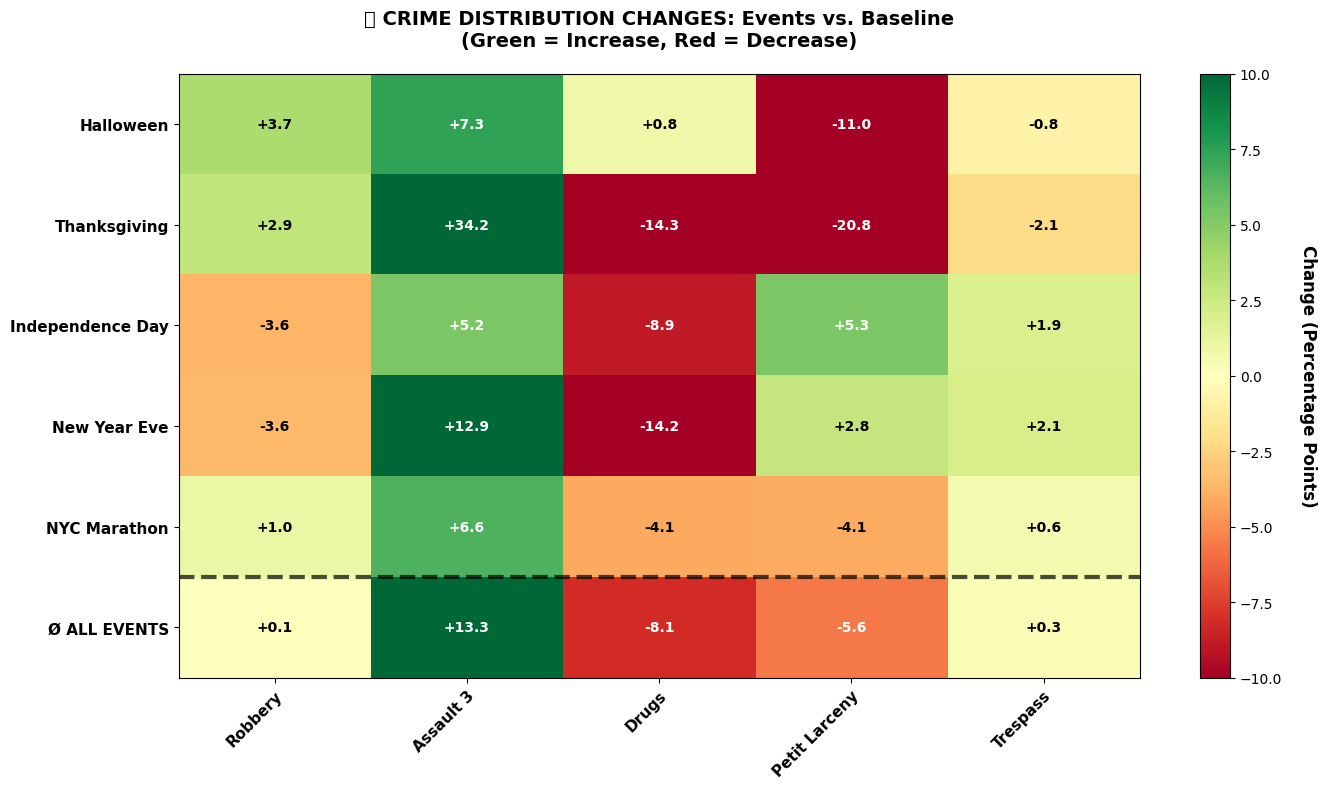


🎉 MULTI-EVENT ANALYSIS COMPLETED!
📁 Saved Files:
   1. multi_event_crime_distribution.png - Detailed plots for each event
   2. multi_event_heatmap.png - Overview of all changes


In [6]:
# ========================================
# HEATMAP: CHANGES ACROSS ALL EVENTS
# ========================================

# Create matrix: Events x Crime Types
change_matrix = []
for event_name in event_names:
    row = [all_results[event_name]['changes'][crime] for crime in relevant_crimes]
    change_matrix.append(row)

# Add average row
avg_row = [np.mean([all_results[e]['changes'][crime] for e in event_names]) for crime in relevant_crimes]
change_matrix.append(avg_row)

# Event names + average
event_labels = event_names + ['Ø ALL EVENTS']
crime_short_labels = [crime_labels.get(c, c) for c in relevant_crimes]

# ===== HEATMAP PLOT =====
fig, ax = plt.subplots(figsize=(14, 8))

# Heatmap with diverging colormap (Red = Decrease, Green = Increase)
im = ax.imshow(change_matrix, cmap='RdYlGn', aspect='auto', vmin=-10, vmax=10)

# Axis labels
ax.set_xticks(np.arange(len(crime_short_labels)))
ax.set_yticks(np.arange(len(event_labels)))
ax.set_xticklabels(crime_short_labels, fontsize=11, fontweight='bold')
ax.set_yticklabels(event_labels, fontsize=11, fontweight='bold')

# Rotate x-labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Text annotations in each cell
for i in range(len(event_labels)):
    for j in range(len(crime_short_labels)):
        value = change_matrix[i][j]
        # Text color depending on background
        text_color = 'white' if abs(value) > 5 else 'black'
        text = ax.text(j, i, f'{value:+.1f}', ha="center", va="center",
                      color=text_color, fontsize=10, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Change (Percentage Points)', rotation=270, labelpad=25, fontsize=12, fontweight='bold')

# Title
ax.set_title('🎉 CRIME DISTRIBUTION CHANGES: Events vs. Baseline\n(Green = Increase, Red = Decrease)', 
            fontsize=14, fontweight='bold', pad=20)

# Highlight average row
ax.axhline(y=len(event_names)-0.5, color='black', linewidth=3, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('multi_event_heatmap.png', dpi=300, bbox_inches='tight')
print("✅ Saved: multi_event_heatmap.png")
plt.show()

print("\n🎉 MULTI-EVENT ANALYSIS COMPLETED!")
print("="*80)
print("📁 Saved Files:")
print("   1. multi_event_crime_distribution.png - Detailed plots for each event")
print("   2. multi_event_heatmap.png - Overview of all changes")
print("="*80)